## Introduction

This project tries to gain a better understanding of the Android app market by analyzing Google Play Store data from 2018. The goal is to answer the following questions:

- Which property of an app is the most useful indicator of how successful it is?
- How can we best predict the success of an app using the other properties?

The two properties that seem to be the most suitable indicators of success are an app's rating and how many times it has been installed. After exploring the data, it seems that installs is slightly better than rating, but neither can be reliably predicted using other properties in the data. With the current approach, it is difficult to characterize what kind of apps tend to be more successful in the Android app market.

## Data description

The dataset contains information on apps in the Google Play Store as of August 2018. Each row is an entry for one app, and there are 12 columns, shown below.

- The 'app' column contains the apps' names.
- 'category' is the category an app belongs to. One app only belongs to one category, as opposed to 'genres', of which each app can have multiple.
- 'rating' is the rating out of 5.
- 'reviews' is the number of user reviews.
- 'size' is the size of the app.
- 'installs' is the approximate number of times an app was installed. For example, '1000+' means that an app was downloaded more than 1,000 times.
- 'last_updated' is the last time an app was updated.
- 'current_ver' is the most current version of an app.
- 'android_ver' is the oldest Android version an app can run on.

The raw data file can be found [here](https://cornell.box.com/s/mrc2y9rkd34l8pdbhkl2ss0bbzsxep6a).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
playstore = pd.read_csv('playstore_data.csv', parse_dates = ['last_updated'], infer_datetime_format = True)
playstore.head()

,app,category,rating,reviews,size,installs,price,content_rating,genres,last_updated,current_ver,android_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,art_and_design,4.1,159,19M,10000+,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3
1,Coloring book moana,art_and_design,3.9,967,14M,100000+,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",art_and_design,4.7,87510,8.7M,1000000+,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3
3,Sketch - Draw & Paint,art_and_design,4.5,215644,25M,10000000+,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2
4,Pixel Draw - Number Art Coloring Book,art_and_design,4.3,967,2.8M,100000+,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4


Kaggle user Lavanya Gupta created this dataset by scraping the Google Play Store. Presumably, the data collection occurred on or around August 8, 2018, since this date is the latest in the last_updated column. Gupta writes that she could not find publicly available data on the Google Play Store, while there were many datasets on the Apple App Store. Upon looking into this issue, she found that the Google Play Store uses "sophisticated modern-day techniques (like dynamic page load) using JQuery", which makes scraping more difficult. About potential uses for her dataset, she writes that "\[a\]ctionable insights can be drawn for developers to work on and capture the Android market".

After downloading this dataset, I converted some of the columns to types that would be easier to use for calculating, for example, changing the number of reviews to integer values and changing last_updated to datetime values. I discovered that some rows were duplicate entries and had to remove them. I also removed a column, 'type', which identified whether apps were free, because the price column could serve this function as well. There were many empty values in the rating column, which I chose to replace with the mean of the valid values.

Some information, such as the precise number of downloads, could not be collected through scraping because the Play Store does not list them. This dataset is a subset of all possible instances; there are 9660 rows (apps) while there were millions of apps in the Google Play Store even in 2018. The criteria for being collected into this dataset is unclear. The original dataset can be found at https://www.kaggle.com/lava18/google-play-store-apps.

## Preregistration statement

#### 1. Predict rating with reviews

Use linear regression to see how accurate it is to predict an app's rating given the number of reviews it has. I think there will be a positive correlation, but it might not be that strong. If we assume that rating measures an app's success, perhaps the number of reviews it has indicates success in some way.

#### 2. Clusters

Check to see if the rating vs reviews scatterplot contains some type of cluster, e.g. by category or by number of installs. Rating doesn't vary much by category, but it's worth checking whether the number of reviews makes a difference. It would also be interesting to see whether apps with certain ratings and number of reviews have a similar number of installs.

## Data analysis

### Describe single variables

First examine the more relevant variables: category, rating, number of reviews, times installed, and price.

#### Category

As shown below, there are 33 categories. There's a surprisingly high number of family apps, more than the next two biggest categories combined. After game and tool apps, there is another gap of about 400 until the next biggest category, business.

In [3]:
playstore['category'].describe()

count       9660
unique        33
top       family
freq        1832
Name: category, dtype: object

In [4]:
playstore['category'].value_counts()

family                 1832
game                    959
tools                   827
business                420
medical                 395
personalization         376
productivity            374
lifestyle               370
finance                 345
sports                  325
communication           315
health_and_fitness      288
photography             281
news_and_magazines      254
social                  239
books_and_reference     222
travel_and_local        219
shopping                202
dating                  171
video_players           163
maps_and_navigation     131
education               119
food_and_drink          112
entertainment           102
auto_and_vehicles        85
libraries_and_demo       84
weather                  79
house_and_home           74
art_and_design           64
events                   64
parenting                60
comics                   56
beauty                   53
Name: category, dtype: int64

#### Rating

The mean rating is fairly high at 4.17 stars and the standard deviation is 0.49. Before the empty values were replaced, the standard deviation was 0.54, which is not too much of a difference from 0.49, so at least replacing the values didn't significantly skew the data.

In [5]:
rating_min = playstore['rating'].min()
rating_max = playstore['rating'].max()
rating_mean = playstore['rating'].mean()
rating_std = playstore['rating'].std()
print('rating\nminimum: {:.1f}\nmaximum: {:.1f}\nmean: {:.2f}\nstandard deviation: {:.2f}'.format(rating_min, rating_max, rating_mean, rating_std))

rating
minimum: 1.0
maximum: 5.0
mean: 4.17
standard deviation: 0.49


From the histogram, the distribution is very skewed to the left. It's worth noting that without the replaced values, the third bin from the right would have around 1500 counts, less than the rightmost bin. Regardless, the plot shows that most apps are rated above 4 stars.

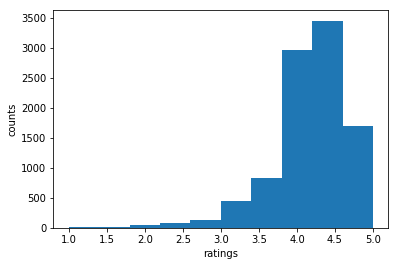

In [6]:
plt.hist(playstore['rating'], range = (1.0, 5.0))
plt.xlabel('ratings')
plt.ylabel('counts')
plt.show()

#### Reviews

The mean and median are very far apart, perhaps indicating that a small number of apps have a disproportionately large number of reviews.

In [7]:
review_min = playstore['reviews'].min()
review_max = playstore['reviews'].max()
review_mean = playstore['reviews'].mean()
review_median = playstore['reviews'].median()
print('reviews\nminimum: {}\nmaximum: {}\nmean: {:.2f}\nmedian: {}'.format(review_min, review_max, review_mean, review_median))

reviews
minimum: 0
maximum: 78158306
mean: 216570.14
median: 967.0


An initial histogram showed that the majority of apps have less than 8 million reviews (which is still a lot), and about half have less than 1000 reviews:

In [8]:
print(str(len(playstore[ playstore['reviews'] < 1000 ])) + ' apps have less than 1000 reviews')

4855 apps have less than 1000 reviews


It appears that the other half have 1000 to one or two million reviews, while a few outliers have especially large numbers of reviews up to eight million.

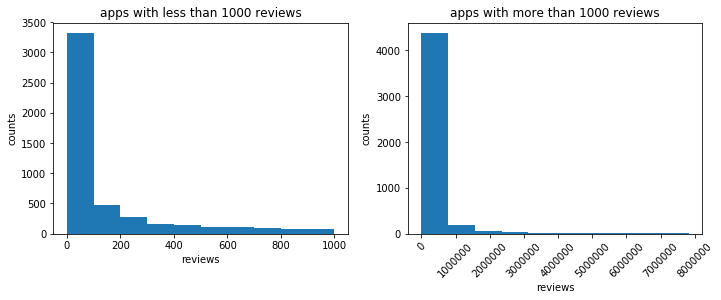

In [9]:
plt.figure(figsize = (10, 4))

# histogram for apps with < 1000 reviews
plt.subplot(1, 2, 1)
plt.hist(playstore[ playstore['reviews'] < 1000 ]['reviews'])
plt.xlabel('reviews')
plt.ylabel('counts')
plt.title('apps with less than 1000 reviews')

# histogram for apps with > 1000 reviews
plt.subplot(1, 2, 2)
plt.hist(playstore[ (playstore['reviews'] > 1000) & (playstore['reviews'] < 8000000) ]['reviews'])
plt.xlabel('reviews')
plt.ylabel('counts')
plt.xticks(rotation = 45)
plt.title('apps with more than 1000 reviews')

plt.tight_layout()
plt.show()

#### Installs

The plot shows an upward trend that drops quickly after 1 to 10 million installs. Most apps are installed a considerable number of times but generally don't reach more than 10 million times.

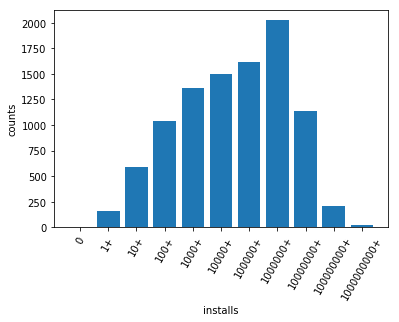

In [10]:
plt.bar(playstore['installs'].value_counts().sort_index().index, playstore['installs'].value_counts().sort_index().values)
plt.xticks(rotation = 60)
plt.xlabel('installs')
plt.ylabel('counts')
plt.show()

#### Price

The vast majority (92%) of apps are free.

In [11]:
price_min = playstore['price'].min()
price_max = playstore['price'].max()
print('price\nminimum: {}\nmaximum: {}'.format(price_min, price_max))
print(str(len(playstore[ playstore['price'] == 0 ])) + ' apps are free')

price
minimum: 0.0
maximum: 400.0
8904 apps are free


Since most apps have a price of 0, a histogram (below left) that includes those is not very informative, so I plotted another graph (below right) that only includes the 700 or so apps that are not free. Of the apps that cost money, most are priced under 50 dollars.

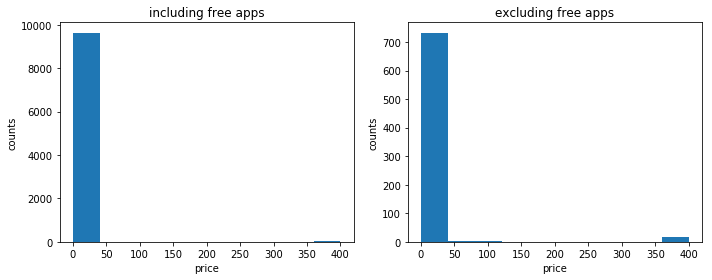

In [12]:
plt.figure(figsize = (10, 4))

# histogram for app prices (including free ones)
plt.subplot(1, 2, 1)
plt.hist(playstore['price'])
plt.xlabel('price')
plt.ylabel('counts')
plt.title('including free apps')

# histogram for app prices (excluding free ones)
plt.subplot(1, 2, 2)
plt.hist(playstore[ playstore['price'] > 0 ]['price'])
plt.xlabel('price')
plt.ylabel('counts')
plt.title('excluding free apps')

plt.tight_layout()
plt.show()

Of tangential interest is the bump on the far right of the histogram that excludes free apps. It seems that the most expensive apps were likely made in imitation of the first [I Am Rich](https://en.wikipedia.org/wiki/I_Am_Rich) app and priced arbitrarily. One could argue that such apps don't productively contribute to discussions about the Android app market, but since it appears that people do buy them, I'll leave them in as part of the data.

In [13]:
playstore[ playstore['price'] > 350 ]

,app,category,rating,reviews,size,installs,price,content_rating,genres,last_updated,current_ver,android_ver
3327,most expensive app (H),family,4.30,6,1.5M,100+,399.99,Everyone,Entertainment,2018-07-16,1.0,7.0
3465,💎 I'm rich,lifestyle,3.80,718,26M,10000+,399.99,Everyone,Lifestyle,2018-03-11,1.0.0,4.4
3469,I'm Rich - Trump Edition,lifestyle,3.60,275,7.3M,10000+,400.00,Everyone,Lifestyle,2018-05-03,1.0.1,4.1
4396,I am rich,lifestyle,3.80,3547,1.8M,100000+,399.99,Everyone,Lifestyle,2018-01-12,2.0,4.0.3
4398,I am Rich Plus,family,4.00,856,8.7M,10000+,399.99,Everyone,Entertainment,2018-05-19,3.0,4.4
4400,I Am Rich Premium,finance,4.10,1867,4.7M,10000+,399.99,Everyone,Finance,2017-11-12,1.6,4.0
4401,I am extremely Rich,lifestyle,2.90,41,2.9M,1000+,379.99,Everyone,Lifestyle,2018-07-01,1.0,4.0
4402,I am Rich!,finance,3.80,93,22M,1000+,399.99,Everyone,Finance,2017-12-11,1.0,4.1
4403,I am rich(premium),finance,3.50,472,965k,1000+,399.99,Everyone,Finance,2017-05-01,3.4,4.4
4406,I Am Rich Pro,family,4.40,201,2.7M,1000+,399.99,Everyone,Entertainment,2017-05-30,1.54,1.6


### Rating given reviews

Assuming that ratings represents an app's success, I was curious to see whether the number of reviews can reliably indicate how successful apps are.

#### Scatterplot of the two variables

In general, apps rated below 3.5 tend to have fewer reviews compared to more highly rated apps, which can even reach nearly 80 million reviews.

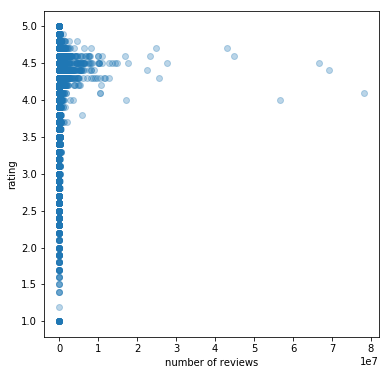

In [14]:
plt.figure(figsize = (6,6))
plt.scatter(playstore['reviews'], playstore['rating'], alpha = 0.3)
plt.xlabel('number of reviews')
plt.ylabel('rating')
plt.show()

#### Linear regression

Before doing using linear regression to check the relationship of the two variables, based on the scatterplot above, I guessed that there would be a positive correlation, though it might not be very strong.

In [15]:
reviews_model = LinearRegression().fit(playstore[ ['reviews'] ], playstore['rating'])
print('coefficient/slope: ' + str(reviews_model.coef_[0]))
print('intercept: ' + str(reviews_model.intercept_))
print('r^2 score: ' + str(reviews_model.score(playstore[ ['reviews'] ], playstore['rating'])))

coefficient/slope: 1.4895833953454203e-08
intercept: 4.169290570239675
r^2 score: 0.003038810095198907


The results of the model show an extremely low correlation coefficient (1.49e-8) and low $r^2$ score (0.003) between rating and reviews, meaning that predicting ratings with the number of reviews is not useful. It seems that apps with enormous numbers of reviews fall in the range of 4 to 4.7 stars. In general, that range of ratings corresponds to an increase in reviews.

#### Check for any clusters

Try grouping by category to see if different categories of apps have different relationships between their ratings and number of reviews. I tried showing all the categories on the plot below, but that was too many to be useful, so I picked the top three categories (family, game, and tools) to make the plot.

In [16]:
sns.set_palette('colorblind')

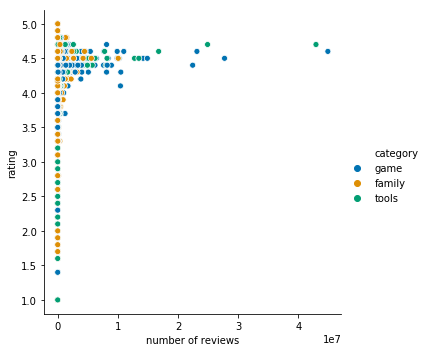

In [17]:
top_categories = playstore.copy()[ (playstore['category'] == 'family') | (playstore['category'] == 'game') | (playstore['category'] == 'tools')]

sns.relplot(x = 'reviews', y = 'rating', data = top_categories, hue = 'category')
plt.xlabel('number of reviews')
plt.ylabel('rating')
plt.show()

From the above plot, there are no obvious clusters visible, but some observations can still be made:

- Ratings of game apps are more concentrated, mostly falling between 4 and 5.
- Family apps have a wide range of ratings and typically don't get many reviews compared to the other two categories.
- Ratings of tools apps are varied as well, though they, along with game apps, can get a large number of reviews.

The bottom line is that category doesn't affect rating and reviews much.

Try grouping by installs instead:

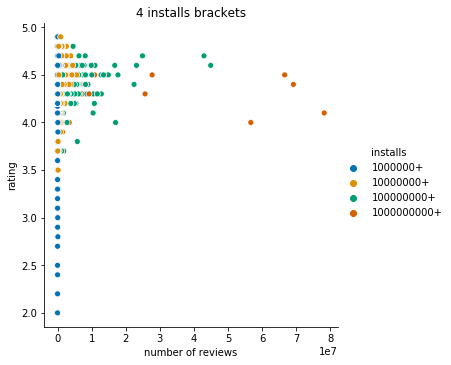

In [18]:
# group according to the 4 highest install brackets
top_installs = playstore.copy()[ (playstore['installs'] == '1000000000+') | (playstore['installs'] == '100000000+') | (playstore['installs'] == '10000000+') | (playstore['installs'] == '1000000+') ]

sns.relplot(x = 'reviews', y = 'rating', data = top_installs, hue = 'installs')
plt.xlabel('number of reviews')
plt.ylabel('rating')
plt.title('4 installs brackets')
plt.show()

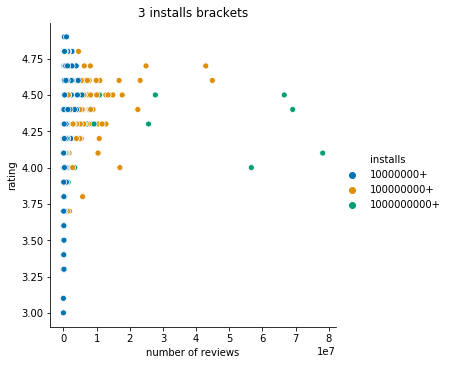

In [19]:
# group according to the 3 highest install brackets
top_installs = top_installs[ (top_installs['installs'] == '1000000000+') | (top_installs['installs'] == '100000000+') | (top_installs['installs'] == '10000000+') ]

sns.relplot(x = 'reviews', y = 'rating', data = top_installs, hue = 'installs')
plt.xlabel('number of reviews')
plt.ylabel('rating')
plt.title('3 installs brackets')
plt.show()

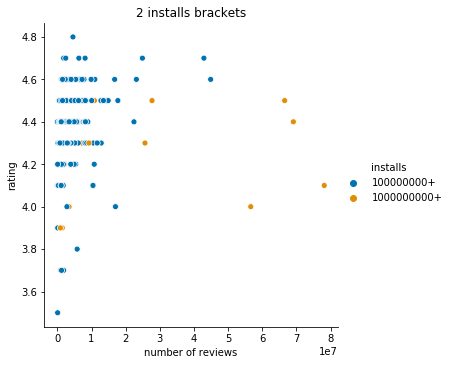

In [20]:
# group according to the 2 highest install brackets
top_installs = top_installs[ (top_installs['installs'] == '1000000000+') | (top_installs['installs'] == '100000000+') ]

sns.relplot(x = 'reviews', y = 'rating', data = top_installs, hue = 'installs')
plt.xlabel('number of reviews')
plt.ylabel('rating')
plt.title('2 installs brackets')
plt.show()

We can see slightly clearer groupings when differentiating by number of installs, where the more reviews an app has, the more installs it has gotten. However, it would still be hard to use actual clustering and predict ratings that way.

I discovered that the number of reviews doesn't necessarily have much to do with rating even considering categories. The most interesting observation for me was that installs might be related to the number of reviews, at least for the higher install brackets, which makes intuitive sense (but doesn't really help answer the research questions).

### Better indicator of success: rating or installs

Given the extremely weak correlation found in the previous section, I started to question the assumption that rating best represents an app's success in the market. There is another possible indicator: how much the app is installed.  

To check whether rating or installs is the more reliable indicator, I tried using multivariate regression models to predict rating and installs with the other relevant variables.

#### For rating:

In [21]:
# map installs categories to integers
installs_map = {'0': 0, '1+': 1, '10+': 2, '100+': 3, '1000+': 4, '10000+': 5, '100000+': 6, '1000000+': 7, '10000000+': 8, '100000000+': 9, '1000000000+': 10}
playstore['installs_map'] = playstore['installs'].map(installs_map)

In [22]:
inputs = ['reviews', 'installs_map', 'price']
rating_multivar_model = LinearRegression().fit(playstore[inputs], playstore['rating'])
for i in range(len(inputs)):
    print(inputs[i] + ' coefficient = {:.4f}'.format(rating_multivar_model.coef_[i]))
print('r-squared = {:.4f}'.format(rating_multivar_model.score(playstore[inputs], playstore['rating'])))

reviews coefficient = 0.0000
installs_map coefficient = 0.0155
price coefficient = -0.0005
r-squared = 0.0068


At 0.007, the $r^2$ score for this model is almost negligible, suggesting that rating cannot be reliably predicted by the other properties of an app.

#### For installs:

In [23]:
inputs = ['rating', 'reviews', 'price']
reviews_multivar_model = LinearRegression().fit(playstore[inputs], playstore['installs_map'])
for i in range(len(inputs)):
    print(inputs[i] + ' coefficient = {:.4f}'.format(reviews_multivar_model.coef_[i]))
print('r-squared = {:.4f}'.format(reviews_multivar_model.score(playstore[inputs], playstore['installs_map'])))

rating coefficient = 0.2224
reviews coefficient = 0.0000
price coefficient = -0.0058
r-squared = 0.0492


The $r^2$ score is 0.05, still very low but better than the score of the last model. As a result, installs is probably slightly better than rating as the indicator of app success despite the inability to predict either from other variables.

### Other things to do for the final submission

Compare installs relationship with other variables

#### installs given other variables

- installs vs rating  
- installs vs reviews
- installs vs price

## Interpretation and conclusions

At first assuming rating to be the best indicator of success, I found that it in fact cannot be reliably predicted by the number of reviews or by all other relevant variables combined. Using linear regression to model the relationship between ratings and reviews, the correlation coefficient and $r^2$ score were both low (1.49e-8 and 0.003 respectively), suggesting that though the relationship may be slightly positive, ratings and reviews are not strongly related.  

Using multivariate linear regression to predict ratings and installs, the two variables most likely to indicate an app's success, I found that neither of them can be accurately modeled even by the combination of three other variables. The model that predicts ratings has an $r^2$ score of 0.007, while the one that predicts installs has an $r^2$ of approximately 0.05. Though both scores are low, the times an app is installed appears to be the better indicator of success (despite the installs column being rough brackets instead of actual numbers).

It seems that there is no reliable way to predict what kind of apps tend to be more successful in the Android app market, at least not by using this approach. One of the possible factors that resulted in this is that the dataset is a small subset of all apps available in the Play Store as of August 2018 (it is estimated that there were about 3 million apps at the time).

## Limitations

- As the data was scraped in early August of 2018, it isn't the most recent. The dataset also does not contain all possible instances.
- There is no column for the date when an app was first released although this information is listed in the Play Store. As a result, the columns that track recent updates and app versions lose some context.
- There were multiple entries with the same name in the app column, and some were listed with different categories and different numbers of reviews. I removed these duplicate rows, which may have affected the data.
- The price column might not account for in-app purchase costs because the app is listed as free in the Play Store.
- The 15% of missing values in the rating column were replaced with the mean value, which affects the accuracy of the data.
- The values in the installs column are threshold indicators, not the actual values, which aren't displayed in the Play Store.

## Acknowledgements

Thanks to:
- The TAs and other students who gave me feedback on different phases of the project.
- Prof. Mimno and the course staff, for teaching the material (obviously) and answering questions on Campuswire.
- [Kaggle](https://www.kaggle.com/datasets), for the raw dataset.
- Countless [Stack Overflow](https://stackoverflow.com/questions) pages that helped me troubleshoot.
- The [pandas](https://pandas.pydata.org/docs/) documentation, mainly for the cheat sheet.
- The [matplotlib](https://matplotlib.org/3.1.1/index.html) documentation, which is slightly confusing but still helped.
- Documentation or tutorials for other packages/tools used, including [numpy](https://numpy.org/doc/), [sklearn](https://scikit-learn.org/stable/), [seaborn](https://seaborn.pydata.org/), etc.

<hr />

### Questions

- (How) should I evaluate significance if the results I got are not that meaningful (e.g. very low correlation scores)?
- I'm thinking about replacing the original NaN values in the rating column with numbers taken randomly from a normal distribution (with mean 4.17 and standard deviation 0.54) instead of just with the mean. Does that make sense or is it completely unnecessary?
- Any problems you see that I should be aware of?

Thanks!